In [18]:
import numpy as np
from scipy.optimize import minimize
import cvxpy as cp  
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics.pairwise import linear_kernel
from sklearn.gaussian_process.kernels import DotProduct
np.random.seed(0)

In [2]:
def sqexp(v, v_prime, z, z_prime, tau, L):
   
    # Square Exponential Kernel
    cov = tau * np.exp(-1/2 * (v - v_prime)**2 / L**2)* tau * np.exp(-1/2 * (z - z_prime)**2 / L**2)
    return cov

In [3]:
def affineDotProductKernel(v, v_prime, z, z_prime, u, u_prime, tau_1, L_1, tau_2, L_2):  ## accept tau , l1, tau2, l2
    #Affine Dot Product Compound Kernel
    
    # Using the square exponential kernel for the two kernels necessary 
    kern1 = sqexp(v, v_prime, z, z_prime, tau_1, L_1)
    kern2 = sqexp(v, v_prime, z, z_prime, tau_2, L_2)   ## Change Tau and L values for each kernel 1 and 2 

    # Stacking required number kernels 
    # here m = 1 since u is one value, therefore m+1 = 2 kernels required
    kernels = np.array([kern1, kern2])

    # Constructing diagonal matric of kernels 
    diagonal_Matrix = np.diag(kernels)

    # Constructing the affine dot product compound kernel
    y = np.array([1, u]).reshape(-1,1)
    y_prime = np.array([1, u_prime]).reshape(-1, 1)
    affine_dot_product_kernel = np.dot(y.T, np.dot(diagonal_Matrix, y_prime))   ## has to be y = [1, u] and y' = [1, u'] find out how the control inputs are different for (v,z) and (v', z')

    return affine_dot_product_kernel

In [4]:
def build_covariance(x, xp, y, yp, func, u_input, u_input_prime, tau_1, L_1, tau_2, L_2): ## take tau1, L1, amd tau2, L2
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    kern = func
    out = np.zeros((x.shape[0], xp.shape[0]))
    for ii in range(x.shape[0]):
        for jj in range(xp.shape[0]):
            out[ii, jj] = kern(x[ii], xp[jj], y[ii], yp[jj], u_input[ii], u_input_prime[jj], tau_1, L_1, tau_2, L_2)
    return out

In [5]:
# True Plant   
def TruePlant(X):
    """
    State X = [v,z]
    v -> forward velcity of ego car
    z -> distance between ego car and front car
    
    """
    f0_true = 0.2
    f1_true = 10
    f2_true = 0.5
    m_true = 3300
    v0 = 14   # m/s
    f_r = f0_true + f1_true*X[0] + f2_true*X[0]**2
    f_X = np.array([(-f_r/m_true), v0 - X[0]]). reshape(-1,1)
    g_X = m_true * np.array([1/m_true, 0]).reshape(-1,1)

    return f_X, g_X


In [6]:
# Nominal Plant
def NominalPlant(X):
    """
    State X = [v,z]
    v -> forward velcity of ego car
    z -> distance between ego car and front car
    
    """
    f0_nom = 0.1
    f1_nom = 5
    f2_nom = 0.25
    m_nom = 1650    
    m_true = 3300
    v0 = 14    # m/s
    f_r = f0_nom + f1_nom*X[0] + f2_nom*X[0]**2
    f_X = np.array([(-f_r/m_nom), v0 - X[0]]). reshape(-1,1)
    g_X = m_true * np.array([1/m_nom, 0]).reshape(-1,1)

    return f_X, g_X


In [7]:
# Function to find LfV + LgV*u (Lyapunov output) for true dynamics (or nominal dynamics???) used for training GP 

def output_V_X(X, u):

    vd = 24  # desired speed command in m/s
    dV_dx = np.array([2*(X[0] - vd), 0]).reshape(1,-1)

    x0_T, x1_T = TruePlant(X)
    x0_N, x1_N = NominalPlant(X) 
    f_X = x0_T - x0_N
    g_X = x1_T - x1_N

    true_out_V = dV_dx @ f_X + dV_dx @ g_X * u

    return true_out_V
    


In [8]:
# Function to find LfH + LgH*u (Barrier output) for true dynamics (or nominal dynamics???) used for training GP 

def output_H_X(X, u):

    Th = 1.8   # Lookahead time in sec
    dH_dx = np.array([-Th, 1]).reshape(1,-1)

    x0_T, x1_T = TruePlant(X)
    x0_N, x1_N = NominalPlant(X) 
    f_X = x0_T - x0_N
    g_X = x1_T - x1_N

    true_out_H = dH_dx @ f_X + dH_dx @ g_X * u

    return true_out_H

In [9]:
np.random.seed(0)
n_total_pts = 100
n_train_pts = 50
v_max = 50
z_max = 100
u_train_test = np.random.uniform(low = -5, high = 5, size = n_total_pts)
v_train_test = np.random.uniform(low = 0, high = v_max, size = n_total_pts)
z_train_test = np.random.uniform(low = 0, high = z_max, size = n_total_pts)

utrain = u_train_test[0:n_train_pts]
utest = u_train_test[n_train_pts:n_total_pts]

vtrain = v_train_test[0:n_train_pts]
vtest = v_train_test[n_train_pts:n_total_pts]

ztrain = z_train_test[0:n_train_pts]
ztest = z_train_test[n_train_pts:n_total_pts]

state_X_train = np.vstack((vtrain, ztrain))
state_X_test = np.vstack((vtest, ztest))

###### Generate Training data outputs for training GP
out_Vx_train = np.zeros((state_X_train[0].shape))
for ii in range(len(state_X_train[0])):
    out_Vx_train[ii] = output_V_X(state_X_train[:,ii], utrain[ii]).squeeze()

out_Hx_train = np.zeros((state_X_train[0].shape))
for ii in range(len(state_X_train[0])):
    out_Hx_train[ii] = output_H_X(state_X_train[:,ii], utrain[ii]).squeeze()


####### Generate true values to compare with GP output
out_Vx_truth = np.zeros((state_X_test[0].shape))
for ii in range(len(state_X_test[0])):
    out_Vx_truth[ii] = output_V_X(state_X_test[:,ii], utest[ii]).squeeze()

out_Hx_truth = np.zeros((state_X_test[0].shape))
for ii in range(len(state_X_test[0])):
    out_Hx_truth[ii] = output_H_X(state_X_test[:,ii], utest[ii]).squeeze()
print(out_Vx_truth)



[  23.20366147   23.83035251  155.0621441    53.94663206 -103.69228201
  124.64088461  -50.11525766   21.98190044   -2.45313844 -104.99840192
   74.14982503  -10.30842853  -37.84045249  139.79971282  150.34996478
   49.33351964  150.31660861  -48.3566847   -84.48303749 -124.55126431
  -19.55227944  -13.34399257  133.49476149   48.38392231  -75.05643535
 -118.00262984  -29.24467745  170.18281611   45.74907565 -170.87139361
  -57.39096715   12.12993449   42.37732377   46.59888178  -30.25131278
   31.42982113   -1.29335438   44.62998886  -18.9958916    72.14537442
  -14.83723835   45.22696063 -108.18036328 -100.4563808    54.65981601
    3.31344091   21.85190182 -108.28462165  138.80310033  -22.57765157]


In [10]:
def max_marg_likelihood(des_var, *args):   ### optimize for tau1, L1, tau2, L2
    inp = args[0]
    tau1, L1, tau2, L2, sigma = des_var
    
    cov = build_covariance(vtrain, vtrain, ztrain, ztrain, affineDotProductKernel, utrain, utrain, tau1, L1, tau2, L2)
    #print("cov from marg like = ", cov)
    n_init = len(state_X_train[0])
    mean_func = np.mean(inp)*np.ones((n_init,1))

    subterm_1 = (inp.reshape(-1,1) - mean_func).T
    subterm_2 = np.linalg.inv(cov + (sigma**2)*np.identity(vtrain.shape[0]))
    subterm_3 = subterm_1.T
    
    term1 = np.dot(subterm_1,np.dot(subterm_2,subterm_3))
    term2 = np.log(np.linalg.det((cov + (sigma**2)*np.identity(vtrain.shape[0]))))
    #print(term2)
    term3 = (n_init)*np.log(2*np.pi)
    
    mx_marg_lh = (1/2)*(term1 + term2 + term3)
    
    return mx_marg_lh
    

In [11]:
const = ((0,None),(0,None),(0,None),(0,None),(0,None))
#results = minimize(max_marg_likelihood,(5, 2, 4, 6, 2), bounds = const,args=(out_Vx_train,))
#results = minimize(max_marg_likelihood,(2, 10, 3, 9, 0.1), bounds = const,args=(out_Vx_train,))
results = minimize(max_marg_likelihood,(35, 28, 36, 26, 0.1), bounds = const,args=(out_Vx_train,))

tau_1_V, L_1_V, tau_2_V, L_2_V, sigma_V = results.x
print(results)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 93.58342512584005
        x: [ 3.131e+01  3.689e+01  3.302e+01  4.023e+01  0.000e+00]
      nit: 4
      jac: [ 7.627e+00  9.084e+00  8.028e+00  4.714e+00  0.000e+00]
     nfev: 156
     njev: 26
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


[ 1.089e+01  2.512e+01  5.469e+00  1.004e+01  0.000e+00]

35, 28, 36, 26, 0.1 

In [12]:
const = ((0,None),(0,None),(0,None),(0,None),(0,None))

#results = minimize(max_marg_likelihood,(5, 5, 4, 5, 0.1), bounds = const, args=(out_Hx_train,))
#results = minimize(max_marg_likelihood,(11, 10, 12, 9, 0.1), bounds = const, args=(out_Hx_train,))

#results = minimize(max_marg_likelihood,(7, 9, 5, 8, 0.1), bounds = const, args=(out_Hx_train,))  ## converged
#results = minimize(max_marg_likelihood,(3.764e+03, 1.106e+04, 0.000e+00, 2.928e+03, 0.000e+00), bounds = const, args=(out_Hx_train,))

results = minimize(max_marg_likelihood,(35, 28, 36, 26, 0.1), bounds = const, args=(out_Hx_train,))   ## converged 

tau_1_H, L_1_H, tau_2_H, L_2_H, sigma_H = results.x
print(results)

C:\Users\ivaishi\AppData\Local\Temp\ipykernel_64608\1194295822.py:15: RuntimeWarning: divide by zero encountered in log
  term2 = np.log(np.linalg.det((cov + (sigma**2)*np.identity(vtrain.shape[0]))))
c:\Users\ivaishi\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 75.24052233119048
        x: [ 3.142e+01  3.731e+01  3.157e+01  4.046e+01  0.000e+00]
      nit: 5
      jac: [-1.114e+01  9.461e+00 -7.918e+00  1.063e+01  0.000e+00]
     nfev: 168
     njev: 28
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


1. [ 5.235e+01  1.599e+02  9.926e-02  3.921e+01  0.000e+00]  (Converged, fun value = 15.401)
2. [ 1.594e+02  5.533e+02  0.000e+00  1.585e+02  0.000e+00]  (Did not converge)
3. [ 3.764e+03  1.106e+04  0.000e+00  2.928e+03  0.000e+00]  (Converged, fun value = 73.925) ## works best
4. [ 6.534e+01  1.505e+02  0.000e+00  3.976e+01  0.000e+00]  (did not converge)
5. [ 3.782e+01  1.086e+02  2.674e-01  5.840e+01  0.000e+00]  (did not converge)

In [13]:
### only for testing GP with randomly generated control inputs for testing 

def gpr_affine(xinit, yinit, controller_init, controller_test, xpred, ypred, output_values, noise_var, ADP_kernel, tau_1, L_1, tau_2, L_2):  ### Return b* and C* from this function instead of mean and covariance
    """Gaussian process regression Algorithm

    Inputs
    -------
    xinit: (N, ) training inputs
    yinit: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    ypred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    ADP_kernel: Affine Dot Product Compound Kernel 
    SQE_kernel: Square Exponential Kernel 
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    # constructing covariance matrix (Gram Matrix Kc) from training datapoints
    Kc = build_covariance(xinit, xinit, yinit, yinit, ADP_kernel, controller_init, controller_init, tau_1, L_1, tau_2, L_2) 
    # print("Kc = ", Kc)
    
    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(Kc + np.diag(noise_var))

    # constructing covariance matrix (Gram Matrix Ky*) from training datapoints and query point
    Y_o = np.vstack((np.ones(xinit.shape), controller_init))
    K_1star = sqexp(xpred, xinit, ypred, yinit, tau_1, L_1)
    K_2star = sqexp(xpred, xinit, ypred, yinit, tau_2, L_2)
    # print(Ky_1star.T[0], yinit[0], Ky_1star*yinit)
    K_istar = np.vstack((K_1star.T, K_2star.T))
    Ky_star = np.multiply(K_istar, Y_o)
    #print("Ky_star = ", Ky_star)

    # Controller input 
    y_star = np.array([1, controller_test]).reshape(-1,1)

    # Calculating predicted mean (scalar value)
    pred_mean = np.dot(np.dot(output_values.T, np.dot(invcov, Ky_star.T)), y_star)

    # Calculating predicted mean (scalar value)
    pred_mean_coefficient = np.dot(output_values.T, np.dot(invcov, Ky_star.T))

    
    # Contructing diagonal of covariance matrix for query point using both kernels
    Kss_1 = sqexp(xpred, xpred, ypred, ypred, tau_1, L_1)
    # print(Kss_1)
    Kss_2 = sqexp(xpred, xpred, ypred, ypred, tau_2, L_2)
    # print(Kss_2)
    Kss = np.hstack((Kss_1.T, Kss_2.T)).reshape(1,-1)
    #print("Kss = ", Kss.shape)
    diag_mat = np.diag([Kss_1, Kss_2])
    #print("Diag_Kss = ", diag_mat)

    # Calculating predicted covariance (scalar value)
    pred_cov = np.dot(y_star.T, np.dot(np.subtract(diag_mat, np.dot(Ky_star, np.dot(invcov, Ky_star.T))), y_star))

    # Calculating predicted covariance (scalar value)
    pred_cov_coefficient = np.subtract(diag_mat, np.dot(Ky_star, np.dot(invcov, Ky_star.T)))

    return pred_mean, pred_cov

mean =  [  23.34534053   24.12885676  154.90843819   53.8011061  -103.1017996
  124.58971801  -50.11270244   22.00783944   -2.63590776 -103.71187791
   74.15938792  -10.26165919  -38.04089767  138.76078298  150.51521418
   49.38297245  148.00606083  -48.17392995  -84.68765155 -124.37054735
  -19.35667335  -13.71878887  133.39796744   46.33449176  -75.08669732
 -117.44094186  -29.42216259  169.87765043   45.74367988 -169.09140911
  -56.98143664   12.01508464   42.38549375   46.27633509  -30.18156242
   31.43031677   -1.40518998   44.62899398  -18.99198861   72.08707484
  -14.74814286   45.09066412 -108.3791102  -100.42447844   54.69064257
    3.33854439   21.73517742 -108.48530371  134.44821597  -22.95287418]
cov =  [1.26097556e-01 1.04286276e-01 2.90375376e-01 1.00155801e-02
 8.91546981e+00 3.08341168e-03 3.28180647e-04 2.10831348e-03
 1.25677272e+00 3.55117208e+00 3.48303395e-04 5.46292246e-02
 1.72118553e-01 1.17617483e+00 3.61151566e-01 1.22781633e-02
 1.39417504e+00 6.21126444e-02 

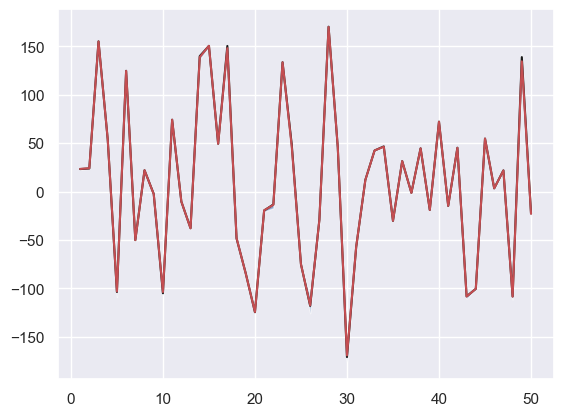

In [14]:
sigma_noise_V = sigma_V * np.ones((state_X_train.shape[1]))
mu_Vx = np.zeros((state_X_test.shape[1]))
cov_Vx = np.zeros((state_X_test.shape[1]))

for jj in range(len(mu_Vx)):
    mu_Vx[jj], cov_Vx[jj] = gpr_affine(vtrain, ztrain, utrain, utest[jj], vtest[jj], ztest[jj], out_Vx_train, sigma_noise_V, affineDotProductKernel, tau_1_V, L_1_V, tau_2_V, L_2_V)

std_Vx = np.sqrt(np.abs(cov_Vx))
print("mean = ", mu_Vx)
print("cov = ", cov_Vx)
print("standard deviation = ", std_Vx)

fig, ax = plt.subplots()
x = np.linspace(1, len(out_Vx_truth), len(out_Vx_truth))
ax.plot(x, out_Vx_truth, 'k')

x_test = np.linspace(1, len(mu_Vx), len(mu_Vx))
ax.plot(x_test, mu_Vx, 'r')
lower = mu_Vx - 1.96*std_Vx
upper = mu_Vx + 1.96*std_Vx
ax.fill_between(x_test, lower, upper, alpha=0.6 )
plt.show()



mean =  [ 1.26631462 -1.10539634  8.78412958 -7.16288274 -5.23137652 -6.09670668
  2.75594398 -4.44088901 -0.60871254 -4.58258652 -6.13867987 -7.01563959
  2.81006442 -6.49473698 -5.46456223 -2.36392132  5.76934412 -7.25227332
  6.08219432 -7.26809918  8.57776857 -0.5714221   8.58049141  1.85596901
  4.30709372 -8.28316007 -3.91272557 -6.83571209 -3.66945011 -6.84142839
 -3.26862383 -1.54404181 -7.84519806  3.46499211  1.19843016 -4.22305904
  0.41925667 -7.30918855  1.36706252  7.72781826 -3.26542665  3.01537709
 -6.62578292  3.89365384 -3.79057573 -5.70255507  1.55951874 -8.63731965
  5.85752765 -8.91995659]
cov =  [ 1.11775820e-01  9.28656630e-02  2.54292183e-01  8.85069130e-03
  7.93982498e+00  2.51855654e-03  2.69960639e-04  1.78213265e-03
  1.12775826e+00  3.16639711e+00  1.64716324e-04  4.79132618e-02
  1.52263206e-01  1.02625446e+00  3.15977304e-01  1.07039313e-02
  1.21481653e+00  5.45692629e-02  9.30604635e-02  3.22004322e-02
  3.75110373e-01  2.60898405e+00  5.21708370e-02  

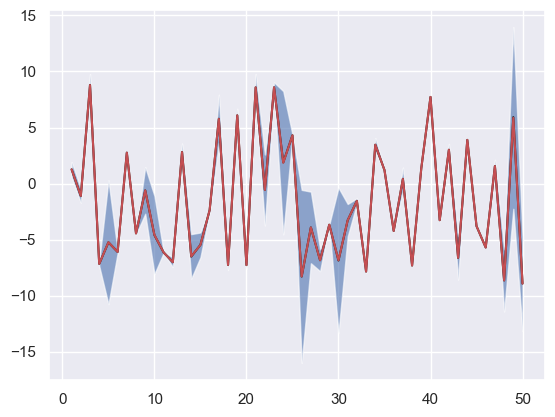

In [15]:
sigma_noise_H = sigma_H * np.ones((state_X_train.shape[1]))
mu_Hx = np.zeros((state_X_test.shape[1]))
cov_Hx = np.zeros((state_X_test.shape[1]))

for jj in range(len(mu_Hx)):
    mu_Hx[jj], cov_Hx[jj] = gpr_affine(vtrain, ztrain, utrain, utest[jj], vtest[jj], ztest[jj], out_Hx_train, sigma_noise_H, affineDotProductKernel, tau_1_H, L_1_H, tau_2_H, L_2_H)

std_Hx = np.sqrt(np.abs(cov_Hx))
print("mean = ", mu_Hx)
print("cov = ", cov_Hx)
print("standard deviation = ", std_Hx)

fig, ax = plt.subplots()
x = np.linspace(1, len(out_Hx_truth), len(out_Hx_truth))
ax.plot(x, out_Hx_truth, 'k')

x_test = np.linspace(1, len(mu_Hx), len(mu_Hx))
ax.plot(x_test, mu_Hx, 'r')
lower = mu_Hx - 1.96*std_Hx
upper = mu_Hx + 1.96*std_Hx
ax.fill_between(x_test, lower, upper, alpha=0.6 )
plt.show()



In [16]:
### only for testing GP with randomly generated control inputs for testing 

def gpr_for_controller(xinit, yinit, controller_init, xpred, ypred, output_values, noise_var, ADP_kernel, tau_1, L_1, tau_2, L_2):  ### Return b* and C* from this function instead of mean and covariance
    """Gaussian process regression Algorithm

    Inputs
    -------
    xinit: (N, ) training inputs
    yinit: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    ypred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    ADP_kernel: Affine Dot Product Compound Kernel 
    SQE_kernel: Square Exponential Kernel 
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    # constructing covariance matrix (Gram Matrix Kc) from training datapoints
    Kc = build_covariance(xinit, xinit, yinit, yinit, ADP_kernel, controller_init, controller_init, tau_1, L_1, tau_2, L_2) 
    
    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(Kc + np.diag(noise_var))

    # constructing covariance matrix (Gram Matrix Ky*) from training datapoints and query point
    Y_o = np.vstack((np.ones(xinit.shape), controller_init))
    K_1star = sqexp(xpred, xinit, ypred, yinit, tau_1, L_1)
    K_2star = sqexp(xpred, xinit, ypred, yinit, tau_2, L_2)
    # print(Ky_1star.T[0], yinit[0], Ky_1star*yinit)
    K_istar = np.vstack((K_1star.T, K_2star.T))
    Ky_star = np.multiply(K_istar, Y_o)
    #print("Ky_star = ", Ky_star)

    # Calculating predicted mean (scalar value)
    pred_mean_coefficient = np.dot(output_values.T, np.dot(invcov, Ky_star.T))

    
    # Contructing diagonal of covariance matrix for query point using both kernels
    Kss_1 = sqexp(xpred, xpred, ypred, ypred, tau_1, L_1)
    Kss_2 = sqexp(xpred, xpred, ypred, ypred, tau_2, L_2)
    diag_mat = np.diag([Kss_1, Kss_2])

    # Calculating predicted covariance (scalar value)
    pred_cov_coefficient = np.subtract(diag_mat, np.dot(Ky_star, np.dot(invcov, Ky_star.T)))

    return pred_mean_coefficient, pred_cov_coefficient

In [133]:
# GP-CBF-CLF-SOCP

# G_V = cp.Parameter((3,2))
# G_h = cp.Parameter((3,2))
# H_V = cp.Parameter((3,1))
# H_h = cp.Parameter((3,1))

f = matrix([0.001, 100.])

alpha = 20
k = 1.0
v0 = 14     # m/s
vd = 24     # m/s
t_h = 1.8   # sec
beta = 2    # confidence interval

# G = matrix([G_V + G_h])
# H = matrix([H_V + H_h])

# problem = solvers.socp(f, Gq = G, hq = H)

class AdaptiveCruiseControl:
    
    def __init__(self, x0, dt):
        self.X = x0
        self.dt = dt
        
    def f_Nom(self):
        f_X,_ = NominalPlant(self.X)
        return f_X
    
    def f_true(self):
        f_X,_ = TruePlant(self.X)
        return f_X
        
    def g_Nom(self):
        _,g_X = NominalPlant(self.X)
        return g_X
    
    def g_true(self):
        _,g_X = TruePlant(self.X)
        return g_X
        
    def barrier(self):
        d_min = t_h * self.X[0,0]
        hx = self.X[1,0] - d_min
        dhx_dx = np.array([-t_h, 1]).reshape(1,-1)
        return hx, dhx_dx

    def lyapunov(self):
        V_val = (self.X[0,0] - vd)**2
        dV_dx = np.array([2*(self.X[0,0] - vd), 0]).reshape(1,-1)
        return V_val, dV_dx

    # use true dynamics            
    def step(self, U):
        self.X = self.X + ( self.f_true() + self.g_true() * U )*self.dt
        return self.X

In [139]:
initial_state = np.array([20, 100]).reshape(-1,1)
dt  = 0.0015
X_state = np.zeros((2,1000))
AdaptCruiseCont = AdaptiveCruiseControl(initial_state, dt)

for i in range(1000):
    
    h, dh_dx = AdaptCruiseCont.barrier()
    V, dV_dx = AdaptCruiseCont.lyapunov()
    test_1 = AdaptCruiseCont.f_Nom()
    # print()
    
    lfh_nom = (dh_dx @ AdaptCruiseCont.f_true())[0][0]
    lgh_nom = (dh_dx @ AdaptCruiseCont.g_true())[0][0]
    lfV_nom = (dV_dx @ AdaptCruiseCont.f_true())[0][0]
    lgV_nom = (dV_dx @ AdaptCruiseCont.g_true())[0][0]

    b_Vx, C_Vx = gpr_for_controller(vtrain, ztrain, utrain, AdaptCruiseCont.X[0], AdaptCruiseCont.X[1], out_Vx_train, sigma_noise_V, affineDotProductKernel, tau_1_V, L_1_V, tau_2_V, L_2_V)
    b_hx, C_hx = gpr_for_controller(vtrain, ztrain, utrain, AdaptCruiseCont.X[0], AdaptCruiseCont.X[1], out_Hx_train, sigma_noise_H, affineDotProductKernel, tau_1_H, L_1_H, tau_2_H, L_2_H)
    
    Gram_hx = np.sqrt(np.abs(C_hx))    ## Construct Gram Matrix of C*
    Gram_Vx = np.sqrt(np.abs(C_Vx)) 

    Q_V = np.array([[beta * Gram_Vx[0, 1], 0],[beta * Gram_Vx[1, 1], 0]])
    # print(Q_V.shape) #G2:m+1
    r_V = (beta * Gram_Vx[:, 0]).reshape(-1,1) #G1
    w_V = np.array([lgV_nom + b_Vx[1], -1]).reshape(-1,1)
    v_V = lfV_nom + b_Vx[0] + k*V

    Q_h = np.array([[beta * Gram_hx[0, 1], 0], [beta * Gram_hx[1, 1], 0]]) #G2:m+1
    r_h = (beta * Gram_hx[:, 0]).reshape(-1,1) #G1
    w_h = np.array([lgV_nom + b_hx[1], 0]).reshape(-1,1)
    v_h = lfh_nom + b_hx[0] + alpha*h

    # print(w_V, Q_V)
    # print(v_V.shape, r_V.shape)
 
    G_V_arr = -(np.vstack([w_V.T, Q_V]))
    G_V = matrix(G_V_arr)
     
    H_V_arr = np.vstack([v_V, r_V])
    H_V = matrix(H_V_arr)

    G_h_arr = -np.vstack([w_h.T, Q_h])
    G_h = matrix(G_h_arr)
    H_h_arr=  np.vstack([v_h, r_h])
    H_h = matrix(H_h_arr)

    G = [G_V, G_h] 
    H  = [H_V, H_h]

    #test = lfV_nom+ lgV_nom*u.value
    #print(test)
    #print(V, dV_dx, lfV_nom, lgV_nom, u, delta)
    problem = solvers.socp(f, Gq = G, hq = H)
    if problem['status'] != 'optimal':
        print("SOCP not solvable")
    
    test = lfV_nom+ lgV_nom*problem['x'][0]
    print("test = ", test)
    print("V=", V, "dvdx= ", dV_dx, "lfv =", lfV_nom, "lgv =", lgV_nom, "u=", problem['x'][0], "delta=", problem['x'][1])
    
    X_state[:,i] = AdaptCruiseCont.step(problem['x'][0]).squeeze()

     pcost       dcost       gap    pres   dres   k/t
 0:  1.6801e+03 -1.2875e+05  1e+05  1e-01  6e+00  1e+00
 1: -9.4406e+03 -1.5410e+05  2e+05  1e-01  7e+00  9e+01
 2: -1.3248e+06 -2.8466e+06  2e+07  1e+00  8e+01  9e+04
 3: -3.8065e+06 -3.9297e+06  9e+06  2e-01  1e+01  2e+05
 4: -3.9100e+08 -3.7581e+08  9e+08  2e-01  1e+01  2e+07
Certificate of dual infeasibility found.
SOCP not solvable
test =  0.9701822848827177
V= 16 dvdx=  [[-8  0]] lfv = 0.9701818181818181 lgv = -8.0 u= -5.8337612448008264e-08 delta= -0.009999999999416625
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6802e+03 -1.2873e+05  1e+05  1e-01  6e+00  1e+00
 1: -9.4402e+03 -1.5408e+05  2e+05  1e-01  7e+00  9e+01
 2: -1.3249e+06 -2.8466e+06  2e+07  1e+00  8e+01  9e+04
 3: -3.8063e+06 -3.9295e+06  9e+06  2e-01  1e+01  2e+05
 4: -3.9098e+08 -3.7580e+08  9e+08  2e-01  1e+01  2e+07
Certificate of dual infeasibility found.
SOCP not solvable
test =  0.9702131757904396
V= 16.001455306518274 dvdx=  [[-8.00036382  0

In [140]:
print(X_state[0])

print(X_state[1])

[19.99981809 19.99963618 19.99945428 19.99927238 19.99909048 19.99890858
 19.99872669 19.9985448  19.99836291 19.99818102 19.99799914 19.99781725
 19.99763537 19.9974535  19.99727162 19.99708975 19.99690788 19.99672601
 19.99654415 19.99636229 19.99618043 19.99599857 19.99581672 19.99563486
 19.99545301 19.99527117 19.99508932 19.99490748 19.99472564 19.9945438
 19.99436197 19.99418014 19.99399831 19.99381648 19.99363465 19.99345283
 19.99327101 19.99308919 19.99290738 19.99272557 19.99254376 19.99236195
 19.99218014 19.99199834 19.99181654 19.99163474 19.99145295 19.99127116
 19.99108937 19.99090758 19.99072579 19.99054401 19.99036223 19.99018045
 19.98999868 19.9898169  19.98963513 19.98945337 19.9892716  19.98908984
 19.98890808 19.98872632 19.98854456 19.98836281 19.98818106 19.98799931
 19.98781757 19.98763582 19.98745408 19.98727235 19.98709061 19.98690888
 19.98672715 19.98654542 19.98636369 19.98618197 19.98600025 19.98581853
 19.98563681 19.9854551  19.98527339 19.98509168 19.

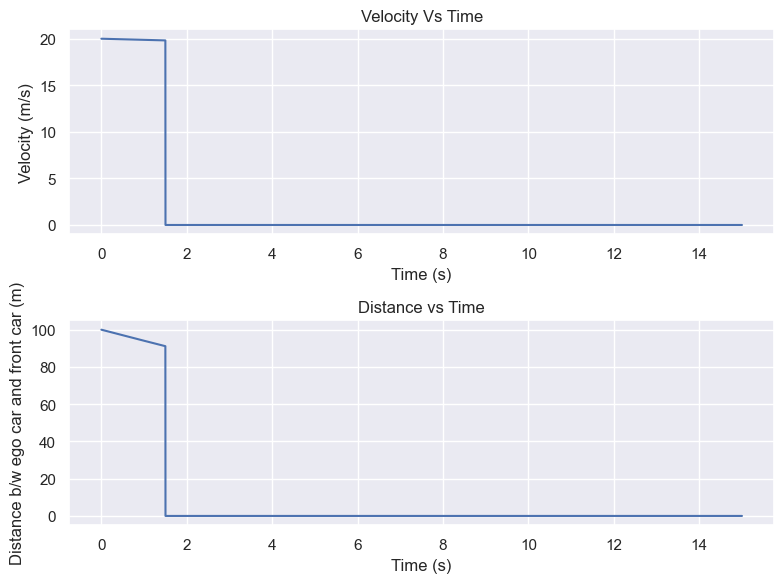

In [136]:
t = np.linspace(0, 15, 10000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot for X_state[0]
ax1.plot(t, X_state[0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Velocity Vs Time')

# Plot for X_state[1]
ax2.plot(t, X_state[1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance b/w ego car and front car (m)')
ax2.set_title('Distance vs Time')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
